In [1]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pylab as plt
import metpy.calc as mpcalc
import numpy as np
import xarray as xr
import cartopy.mpl.ticker as cticker
import metpy.constants as constants
import cmaps
import matplotlib.patches as patches
from  scipy  import stats
import warnings
warnings.filterwarnings("ignore") 
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.weight"] = "bold"

In [2]:
file_temp = xr.open_dataset("/public/home/songqh/my_data/ERA5/monthly/TEMPERATURE/ERA5-temp.nc")
file_humi = xr.open_dataset("/public/home/songqh/my_data/ERA5/monthly/SPECIFIC_HUMIDITY/ERA5_spec_humid.nc")
file_hgt = xr.open_dataset("/public/home/songqh/my_data/ERA5/monthly/HGT/ERA5-hgt.nc")
file_uwnd = xr.open_dataset("/public/home/songqh/my_data/ERA5/monthly/UWND/ERA5-uwnd.nc")
file_vwnd = xr.open_dataset("/public/home/songqh/my_data/ERA5/monthly/VWND/ERA5-vwnd.nc")
temp_data = file_temp['t'].loc[file_temp.time.dt.month.isin(7),1,100:1000,:,:]
humi_data = file_humi['q'].loc[file_humi.time.dt.month.isin(7),1,100:1000,:,:]
uwnd_data = file_uwnd['u'].loc[file_uwnd.time.dt.month.isin(7),1,100:1000,:,:]
vwnd_data = file_vwnd['v'].loc[file_vwnd.time.dt.month.isin(7),1,100:1000,:,:]
hgt_data = file_hgt['z'].loc[file_vwnd.time.dt.month.isin(7),1,100:1000,:,:]
temp = np.array(temp_data)
humi = np.array(humi_data)
uwnd = np.array(uwnd_data)
vwnd = np.array(vwnd_data)
hgt = np.array(hgt_data)
lat = file_temp.latitude.loc[:]
lon = file_temp.longitude.loc[:]
lev = file_temp.level.loc[100:1000]
lev


<xarray.DataArray 'level' (level: 11)>
array([ 100,  150,  200,  250,  300,  400,  500,  700,  850,  925, 1000],
      dtype=int32)
Coordinates:
  * level    (level) int32 100 150 200 250 300 400 500 700 850 925 1000
Attributes:
    units:      millibars
    long_name:  pressure_level

In [3]:
lv = 2.5008e6
cpv = 1846.1
cw = 4218.0
q_u = uwnd*humi/constants.g
q_v = vwnd*humi/constants.g
dx, dy = mpcalc.lat_lon_grid_deltas(lon, lat)
div_q = np.zeros((44,lev.shape[0],lat.shape[0],lon.shape[0]))
for t in range(44):
    for i in range(lev.shape[0]):
        div_q[t,i] = mpcalc.divergence(u = q_u[t,i],v = q_v[t,i],dx = dx ,dy = dy)
elate = div_q * (lv+(cpv-cw)*temp)
elate_index = np.trapz(elate[:,::-1,55:76,60:80],lev[::-1],axis=1).mean((1,2)) #ism:55-76,60-80 

### latent-heat-flux-divergence (elate montioned above) dataset can download from https://doi.org/10.24381/cds.c2451f6b

PearsonRResult(statistic=-0.9771860527350968, pvalue=6.862709906552739e-30)

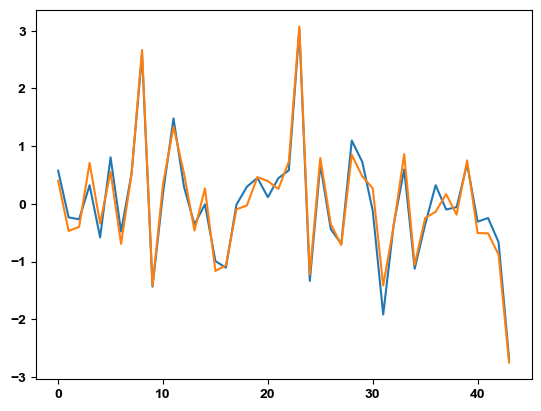

In [4]:
file_lhdiv = xr.open_mfdataset("/public/home/songqh/my_data/ERA5/monthly/INTEG_DIV_LATENT_HEAT/latent-heat-flux-divergence_monthly_*07_v1.0.nc")
lhdiv = file_lhdiv['lhdiv'].loc[:,15:35,60:80].mean(('longitude','latitude'))
lhdiv = lhdiv.values
plt.plot((lhdiv - np.mean(lhdiv))/np.std(lhdiv))
plt.plot(-(elate_index - np.mean(elate_index))/np.std(elate_index))
stats.pearsonr(lhdiv,elate_index)

In [5]:
total_qu_ano = np.trapz(q_u[:,:,:,:],lev[:],axis=1) - np.trapz(q_u[:,:,:,:],lev[:],axis=1).mean((0))
total_qv_ano = np.trapz(q_v[:,:,:,:],lev[:],axis=1) - np.trapz(q_v[:,:,:,:],lev[:],axis=1).mean((0))
total_qu_ano.shape

(44, 181, 360)

In [6]:
file_pre = xr.open_dataset("/public/home/songqh/my_data/NCEP2/monthly/precipitation_monthly/GPCP.precip.mon.mean.nc")
pre_data = file_pre['precip'].loc[file_pre.time.dt.month==7][:-1]
prep_ano = pre_data - pre_data.mean('time')
lon1 = file_pre['lon']
lat1 = file_pre['lat']
pre_ism = pre_data.loc[:,15:35,60:80].mean(('lat','lon')) # ISM
r,p = stats.pearsonr(elate_index,pre_ism)
print(r,p)

0.8984839636755783 1.305168862768725e-16


In [7]:
elate_index = (elate_index - np.mean(elate_index)) / np.std(elate_index)
pre_ism = (pre_ism - np.mean(pre_ism)) / np.std(pre_ism)

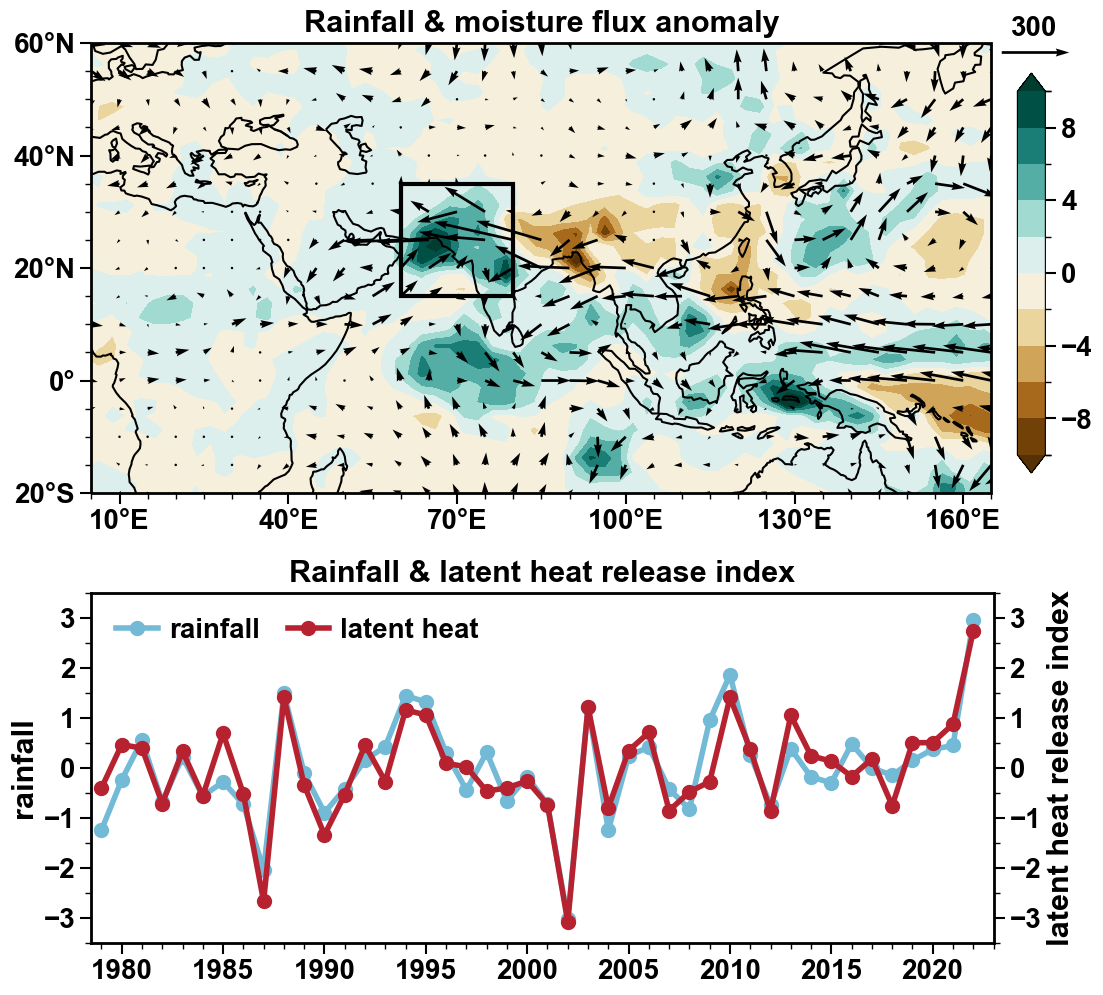

In [11]:

proj = ccrs.PlateCarree(central_longitude=60)
fig = plt.figure(figsize=(14,10))
ax1 = fig.add_axes([0.05,0.5,0.85,0.45],projection = proj)
leftlon, rightlon, lowerlat, upperlat = (5,165,-20,60)
img_extent = [leftlon, rightlon, lowerlat, upperlat]
ax1.set_extent(img_extent, crs=ccrs.PlateCarree())
ax = plt.gca()
ax.spines['geo'].set_linewidth(2)
ax1.tick_params(direction='out', length=8, width=1.5, labelsize=20,axis='both', which='major')
ax1.add_feature(cfeature.LAND.with_scale('110m'),color='lightgray') 
ax1.add_feature(cfeature.COASTLINE.with_scale('110m'),lw=1.5) 
ax1.set_xticks(np.arange(10,180,30), crs=ccrs.PlateCarree())
ax1.set_yticks(np.arange(lowerlat,upperlat+20,20), crs=ccrs.PlateCarree())
ax1.add_patch(patches.Rectangle([0,15],20,20,linewidth=3,edgecolor='k',facecolor='none',zorder=100))
lon_formatter = cticker.LongitudeFormatter()
lat_formatter = cticker.LatitudeFormatter()
ax1.xaxis.set_major_formatter(lon_formatter)
ax1.yaxis.set_major_formatter(lat_formatter)
ax1.minorticks_on()
ax1.tick_params(which='minor', direction='out', bottom=True, length=4, width=1)
ax1.xaxis.set_minor_locator(plt.MultipleLocator(5))
ax1.yaxis.set_minor_locator(plt.MultipleLocator(5))
ax1.set_title("Rainfall & moisture flux anomaly",fontsize=22,weight='bold',loc='center',pad=8)
q = ax1.quiver(lon[::5],lat[::5],total_qu_ano[-1,::5,::5],total_qv_ano[-1,::5,::5],scale=40,width=0.003,zorder=10,
           transform=ccrs.PlateCarree())
qk = ax1.quiverkey(q, 1.048, 0.98, U=3, label='300',labelpos='N',zorder=30000, coordinates='axes',color='k',fontproperties={'size': 20},labelcolor='k')
cf1 = ax1.contourf(lon1,lat1,prep_ano[-1], zorder=1,levels=np.linspace(-10,10,11),  
                   extend = 'both',transform=ccrs.PlateCarree(), cmap=cmaps.MPL_BrBG)
pos = fig.add_axes([0.815,0.52,0.02,0.4])
cb = fig.colorbar(cf1,orientation='vertical',cax=pos)
cb.ax.minorticks_on()
cb.ax.tick_params(which='minor', direction='out', bottom=True, length=4, width=1,labelsize=20)
cb.ax.tick_params(which='major', direction='out', bottom=True, length=8, width=1.5,labelsize=20)
cb.ax.yaxis.set_minor_locator(plt.MultipleLocator(2))

ax2 = fig.add_axes([0.1535,0.05,0.6445,0.35])
ax2.plot(np.arange(1979,2023),pre_ism,color=[115/255,186/255,214/255],lw=4,marker='o',markersize=10,label='rainfall')
ax2.set_ylim(-3.5,3.5)
ax2.set_yticks([-3,-2,-1,0,1,2,3])
ax2.set_xlim(1978.5,2023)
ax2.minorticks_on()
ax2.tick_params(which='minor', direction='out', bottom=True, length=4, width=1)
ax2.xaxis.set_minor_locator(plt.MultipleLocator(1))
ax2.yaxis.set_minor_locator(plt.MultipleLocator(0.5))
ax2.set_title('Rainfall & latent heat release index',loc='center',fontsize=22,pad=8,weight='bold')

ax2.tick_params(direction='out', length=8, width=1.5, labelsize=20,axis='both', which='major')
ax2.set_ylabel("rainfall",fontsize=22)
ax = plt.gca()
for spine in ax.spines.values():
    spine.set_linewidth(2)
ax22 = ax2.twinx()
ax22.set_ylim([-3.5,3.5])
ax22.set_yticks([-3,-2,-1,0,1,2,3])
ax22.tick_params(direction='out', length=8, width=1.5, labelsize=20,axis='both', which='major')
ax22.minorticks_on()
ax22.set_ylabel("latent heat release index",fontsize=22)
ax22.tick_params(which='minor', direction='out', bottom=True, length=4, width=1)
ax22.yaxis.set_minor_locator(plt.MultipleLocator(0.5))
ax22.xaxis.set_minor_locator(plt.MultipleLocator(1))
ax22.plot(np.arange(1979,2023),elate_index,color=[183/255,34/255,48/255],lw=4,marker='o',markersize=10,label='latent heat')
lines, labels = ax2.get_legend_handles_labels()
lines1, labels1 = ax22.get_legend_handles_labels()
ax2.legend(lines + lines1, labels + labels1,ncol=2,frameon=False,handlelength=1.5,
           handletextpad=0.4,columnspacing=1,fontsize=20,loc='upper left')

# fig.savefig("/public/home/songqh/project/figures/figure-4.jpg",dpi=600)
# fig.savefig("/public/home/songqh/project/figures/figure-4.tiff",dpi=600)
plt.show()